In [1]:
import os
from exp_framework.Ensemble import Ensemble, PretrainedEnsemble, StudentExpertEnsemble
from exp_framework.delegation import (
    DelegationMechanism,
    UCBDelegationMechanism,
    ProbaSlopeDelegationMechanism,
    RestrictedMaxGurusDelegationMechanism,
    StudentExpertDelegationMechanism,
)
from exp_framework.learning import Net
from exp_framework.experiment import (
    Experiment,
    calculate_avg_std_test_accs,
    calculate_avg_std_train_accs,
    calculate_avg_std_test_accs_per_trial,
)
from avalanche.training.supervised import Naive
from matplotlib import pyplot as plt
from exp_framework.data_utils import Data
from avalanche.benchmarks.classic import RotatedMNIST, SplitMNIST
import numpy as np
import matplotlib as mpl
import seaborn as sns
from itertools import product
import pandas as pd
import torch.optim as optim
from torch.nn import CrossEntropyLoss

from avalanche.training.plugins import (
    CWRStarPlugin,
    ReplayPlugin,
    EWCPlugin,
    TrainGeneratorAfterExpPlugin,
    LwFPlugin,
    SynapticIntelligencePlugin,
)
from exp_framework.MinibatchEvalAccuracy import MinibatchEvalAccuracy
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics

/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### learning the mapping $\mathcal{X} \rightarrow \mathcal{G}$ (i.e. $\mathcal{X} \rightarrow \mathcal{Y}\times\mathcal{C}$)

### Set up global experiment settings

In [2]:
batch_size = 128
window_size = 400
num_trials = 10
n_voters = 8

#### Create Delegation Mechanisms

### Create Delegation Mechanisms and Ensembles

For simplicity, only explore full ensemble and variants of ProbaSlopeDelegationMechanism since they can be created programmatically.

In [3]:
def get_ensembles_dict(lo_num_gurus=[1, 2, 3, 4]):
    NOOP_del_mech = DelegationMechanism(batch_size=batch_size, window_size=window_size)
    NOOP_del_mech2 = DelegationMechanism(batch_size=batch_size, window_size=window_size)

    probability_functions = [
        "random_better",
        "probabilistic_better",
        "probabilistic_weighted",
        "max_diversity",
    ]
    score_functions = [
        "accuracy_score",
        "balanced_accuracy_score",
        "f1_score",
        # "precision_score",
        # "recall_score",
        # "top_k_accuracy_score",
        # "roc_auc_score",
        # "log_loss_score",
        # "max_diversity",
    ]
    # probability_functions = ["max_diversity"]
    # score_functions = ["accuracy_score"]

    del_mechs = {"full-ensemble": NOOP_del_mech}
    for prob_func, score_func in product(probability_functions, score_functions):
        for num_gurus in lo_num_gurus:
            dm = ProbaSlopeDelegationMechanism(
                batch_size=batch_size,
                window_size=window_size,
                max_active=num_gurus,
                probability_function=prob_func,
                score_method=score_func,
            )
            del_mechs[f"{prob_func}-{score_func}-num_gurus-{num_gurus}"] = dm

    for num_train_gurus in lo_num_gurus:
        for num_test_gurus in lo_num_gurus:
            dm = StudentExpertDelegationMechanism(
                batch_size=batch_size,
                window_size=window_size,
                max_active_train=num_train_gurus,
                max_active_test=num_test_gurus,
            )
            del_mechs[
                f"StudentExpert-num_train_gurus-{num_train_gurus}-num_test_gurus-{num_test_gurus}"
            ] = dm

    ensembles_dict = {
        dm_name: Ensemble(
            training_epochs=1,
            n_voters=n_voters,
            delegation_mechanism=dm,
            name=dm_name,
            input_dim=28 * 28,
            output_dim=10,
        )
        for dm_name, dm in del_mechs.items()
    }
    ensembles_dict["single_Net"] = Ensemble(
        training_epochs=1,
        n_voters=1,
        delegation_mechanism=NOOP_del_mech2,
        name="single_Net",
        input_dim=28 * 28,
        output_dim=10,
    )
    return ensembles_dict

#### Create Avalanche Strategies to Compare Against

In [4]:
def initialize_strategies_to_evaluate():
    plugins_to_evaluate = {
        "LwF": LwFPlugin(),
        "EWC": EWCPlugin(ewc_lambda=0.001),
        "SynapticIntelligence": SynapticIntelligencePlugin(si_lambda=0.5),
        # "Replay": ReplayPlugin(mem_size=100),
    }

    strategies_to_evaluate = {}
    for name, pte in plugins_to_evaluate.items():
        model = Net(input_dim=28 * 28, output_dim=10, width=512)
        optimize = optim.Adam(model.parameters(), lr=0.001)

        mb_eval = MinibatchEvalAccuracy()
        evp = EvaluationPlugin(
            accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            mb_eval,
        )
        cl_strategy = Naive(
            model=model,
            optimizer=optimize,
            criterion=CrossEntropyLoss(),
            train_mb_size=batch_size,
            train_epochs=1,
            eval_mb_size=batch_size,
            # plugins=[pte, evp],
            plugins=[pte, evp, mb_eval],
        )
        strategies_to_evaluate[name] = (cl_strategy, evp)

    return strategies_to_evaluate

# Single Active Voter

### Train Ensemble - single active voter

In [5]:
# Train ensembles - single guru

data = RotatedMNIST(n_experiences=5, seed=0)

ensembles_dict = get_ensembles_dict()

exp = Experiment(
    n_trials=num_trials,
    ensembles=list(ensembles_dict.values()),
    benchmark=data,
    strategies_to_evaluate=initialize_strategies_to_evaluate,
)
_ = exp.run()

  0%|          | 0/10 [00:00<?, ?it/s]

Starting trial  0


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 469/469 [00:16<00:00, 29.09it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2547
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9251
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:15<00:00, 29.58it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2497
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9264
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:17<00:00, 26.51it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2532
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9247
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:16<00:00, 28.32it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9809
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9100
-- >> End of training phase << --
-- >> Start 

 10%|█         | 1/10 [1:13:23<11:00:33, 4403.77s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.1040
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9666
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.9577
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4485
Starting trial  1


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 469/469 [00:15<00:00, 29.86it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2549
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9255
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:15<00:00, 30.01it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2544
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9240
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:16<00:00, 27.81it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2519
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9245
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:16<00:00, 28.26it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9767
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9105
-- >> End of training phase << --
-- >> Start 

 20%|██        | 2/10 [2:19:45<9:14:04, 4155.56s/it] 


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.1114
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9656
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 3.1043
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4360
Starting trial  2


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.72it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2493
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9269
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2588
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9244
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 31.36it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2523
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9235
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 31.89it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9711
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9107
-- >> End of training phase << --
-- >> Start 

 30%|███       | 3/10 [3:11:07<7:07:35, 3665.09s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.1059
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9675
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.9659
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4509
Starting trial  3


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2552
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9246
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2545
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9258
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 31.63it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2572
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9235
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:15<00:00, 31.25it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9502
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9110
-- >> End of training phase << --
-- >> Start 

 40%|████      | 4/10 [4:07:56<5:56:26, 3564.38s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.1189
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9618
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.6789
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4811
Starting trial  4


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2526
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9249
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2598
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9229
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:15<00:00, 31.16it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2540
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9244
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 31.34it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9625
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9104
-- >> End of training phase << --
-- >> Start 

 50%|█████     | 5/10 [4:58:39<4:41:21, 3376.26s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0922
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9717
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.7822
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4609
Starting trial  5


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 469/469 [00:13<00:00, 33.65it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2602
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9228
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 33.39it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2544
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9247
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2573
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9234
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 31.79it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9499
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9133
-- >> End of training phase << --
-- >> Start 

 60%|██████    | 6/10 [5:47:33<3:35:03, 3225.83s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.1042
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9660
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.8165
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4476
Starting trial  6


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2565
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9243
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2563
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9239
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:15<00:00, 31.23it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2563
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9239
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9546
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9129
-- >> End of training phase << --
-- >> Start 

 70%|███████   | 7/10 [6:40:40<2:40:39, 3213.06s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.1058
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9678
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.9045
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4467
Starting trial  7


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2510
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9258
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.90it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2536
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9250
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:15<00:00, 31.26it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2465
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9265
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:15<00:00, 30.94it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9613
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9105
-- >> End of training phase << --
-- >> Start 

 80%|████████  | 8/10 [7:33:57<1:46:56, 3208.09s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0943
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9713
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.8042
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4418
Starting trial  8


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.66it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2522
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9252
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.90it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2588
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9242
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2484
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9253
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:15<00:00, 31.26it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9847
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9074
-- >> End of training phase << --
-- >> Start 

 90%|█████████ | 9/10 [8:25:13<52:46, 3166.77s/it]  

Starting trial  9


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 469/469 [00:13<00:00, 33.84it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2594
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9237
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:13<00:00, 33.72it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2576
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9232
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 32.16it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2529
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9246
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 31.96it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9513
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9099
-- >> End of training phase << --
-- >> Start 

100%|██████████| 10/10 [9:13:29<00:00, 3321.00s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.1158
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9630
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 3.0857
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4296


### Save and Print Results

In [6]:
batch_metrics = exp.get_aggregate_batch_metrics()
dfs = []
for ens, metric_dict in batch_metrics.items():
    df = pd.DataFrame.from_dict(metric_dict, orient="index")
    df["ensemble_name"] = ens
    dfs.append(df)
single_active_df = pd.concat(dfs)
col_order = [len(single_active_df.columns) - 1] + list(
    range(len(single_active_df.columns) - 1)
)
single_active_df = single_active_df[single_active_df.columns[col_order]]
file_prefix = f"domain_incremental_single_guru-trials={num_trials}-batch_size={batch_size}_window_size={window_size}-feb10"
path = "results"

if not os.path.exists(path):
    os.mkdir(path)

filepath = f"{path}/{file_prefix}.csv"
single_active_df.to_csv(filepath)

In [7]:
# Print results - single guru

# Collect and print train accuracies - aggregate and by batch
train_results_dict = dict()
for ens_name, ensemble in ensembles_dict.items():
    train_acc, train_acc_std = calculate_avg_std_train_accs(exp, ens_name, num_trials)
    train_results_dict[ens_name] = (train_acc, train_acc_std)

for strat_name, (strat, eval_plugin) in initialize_strategies_to_evaluate().items():
    train_acc, train_acc_std = calculate_avg_std_train_accs(exp, strat_name, num_trials)
    train_results_dict[strat_name] = (train_acc, train_acc_std)

for ens_name, (train_acc, train_acc_std) in train_results_dict.items():
    print(
        f"Mean train acc for {ens_name}: {round(np.mean(train_acc), 3)}+-{round(np.mean(train_acc_std), 3)}"
    )
# for ens_name, (train_acc, train_acc_std) in train_results_dict.items():
#     print(f"All train accs for {ens_name}: {train_acc}")

print("--------------")

# Collect and print test accuracies
# results_dict = dict()
# for ens_name, ensemble in ensembles_dict.items():
#     test_acc, test_acc_std = calculate_avg_std_test_accs(exp, ens_name, num_trials)
#     results_dict[ens_name] = (test_acc, test_acc_std)

# for strat_name, (strat, eval_plugin) in initialize_strategies_to_evaluate().items():
#     test_acc, test_acc_std = calculate_avg_std_test_accs(exp, strat_name, num_trials)
#     results_dict[strat_name] = (test_acc, test_acc_std)

# for ens_name, (test_acc, test_acc_std) in results_dict.items():
#     print(
#         f"Mean test acc for {ens_name}: {round(np.mean(test_acc), 3)}+-{round(np.mean(test_acc_std), 3)}"
#     )

results_dict = dict()

for ens_name, ensemble in ensembles_dict.items():
    test_acc, _ = calculate_avg_std_test_accs_per_trial(exp, ens_name, num_trials)
    print(
        f"Mean test acc for {ens_name}: {round(np.mean(test_acc), 3)}+-{round(np.std(test_acc), 3)}"
    )
    results_dict[ens_name] = (np.mean(test_acc), np.std(test_acc))

for strat_name, (strat, eval_plugin) in initialize_strategies_to_evaluate().items():
    test_acc, _ = calculate_avg_std_test_accs_per_trial(exp, strat_name, num_trials)
    print(
        f"Mean test acc for {strat_name}: {round(np.mean(test_acc), 3)}+-{round(np.std(test_acc), 3)}"
    )
    results_dict[strat_name] = (np.mean(test_acc), np.std(test_acc))

Mean train acc for full-ensemble: 0.92+-0.021
Mean train acc for random_better-accuracy_score-num_gurus-1: 0.9+-0.037
Mean train acc for random_better-accuracy_score-num_gurus-2: 0.911+-0.026
Mean train acc for random_better-accuracy_score-num_gurus-3: 0.915+-0.023
Mean train acc for random_better-accuracy_score-num_gurus-4: 0.914+-0.022
Mean train acc for random_better-balanced_accuracy_score-num_gurus-1: 0.9+-0.036
Mean train acc for random_better-balanced_accuracy_score-num_gurus-2: 0.912+-0.026
Mean train acc for random_better-balanced_accuracy_score-num_gurus-3: 0.915+-0.023
Mean train acc for random_better-balanced_accuracy_score-num_gurus-4: 0.915+-0.022
Mean train acc for random_better-f1_score-num_gurus-1: 0.9+-0.036
Mean train acc for random_better-f1_score-num_gurus-2: 0.91+-0.027
Mean train acc for random_better-f1_score-num_gurus-3: 0.915+-0.023
Mean train acc for random_better-f1_score-num_gurus-4: 0.913+-0.023
Mean train acc for probabilistic_better-accuracy_score-num_gu

/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


In [8]:
df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["mean", "std"])
df = df.reset_index()
df = df.rename(columns={"index": "name"})
df = df.sort_values(by="mean", ascending=False, ignore_index=True)
# write to csv in results/keepers/class_inc_avgs.csv
df.to_csv("results/keepers/domain_inc_avgs-feb11.csv")

# Explore Results

(leftover copied code from other file, not adapted for the above code)

NameError: name 'full_avg_test_accs' is not defined

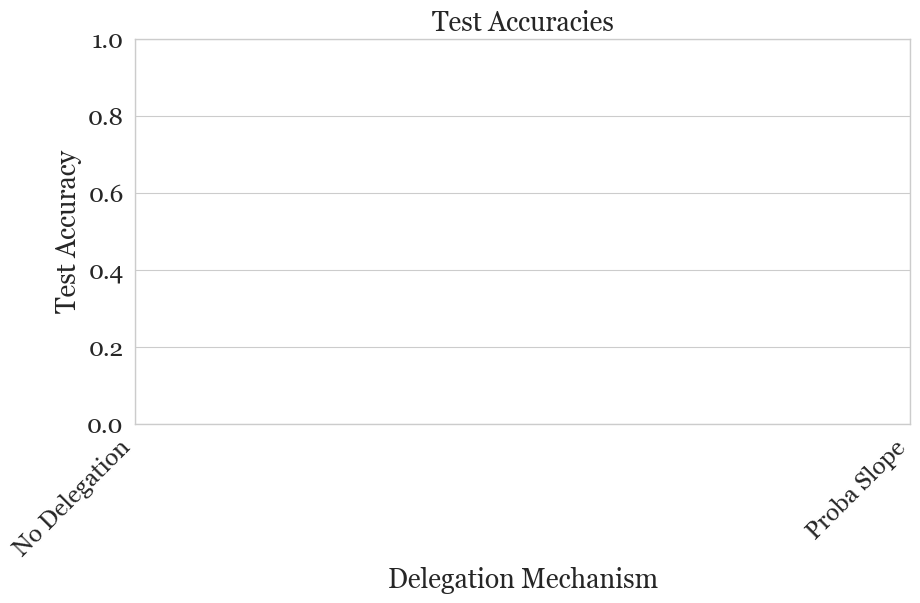

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Georgia"

# set colors for each bar. Use pastel
colors = sns.color_palette("pastel")
# assign colors for each bar

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title("Test Accuracies")
ax.set_ylabel("Test Accuracy")
ax.set_xlabel("Delegation Mechanism")
# ax.set_xticks([0, 1, 2])
# ax.set_xticklabels(
#     ["No Delegation", "Proba Slope", "Restricted Max Guru"], rotation=45, ha="right"
# )
ax.set_xticks([0, 1])
ax.set_xticklabels(["No Delegation", "Proba Slope"], rotation=45, ha="right")
# Data for bar plot
means = [
    np.mean(full_avg_test_accs),
    np.mean(proba_slope_avg_test_accs),
    # np.mean(restricted_max_guru_avg_test_accs),
]
stds = [
    np.std(full_avg_test_accs),
    np.std(proba_slope_avg_test_accs),
    # np.std(restricted_max_guru_avg_test_accs),
]

# Create each bar individually to set different colors
for i in range(len(ensembles)):
    ax.bar(i, means[i], color=colors[i], yerr=stds[i], capsize=10)

plt.tight_layout()
plt.show()

In [ ]:
proba_slope_avg_train_accs, proba_slope_std_train_accs = calculate_avg_std_train_accs(
    exp, "proba_slope_delegations", num_trials
)
full_avg_train_accs, full_std_train_accs = calculate_avg_std_train_accs(
    exp, "full_ensemble", num_trials
)

# (
#     restricted_max_guru_avg_train_accs,
#     restricted_max_guru_std_train_accs,
# ) = calculate_avg_std_train_accs(exp, "restricted_max_guru_delegations", num_trials)

print(
    "Mean train accs for proba_slope delegation ensemble: ",
    np.mean(proba_slope_avg_train_accs),
)
print("Mean train accs for full ensemble: ", np.mean(full_avg_train_accs))

# print(
#     "Mean train accs for restricted_max_guru delegation ensemble: ",
#     np.mean(restricted_max_guru_avg_train_accs),
# )

In [ ]:
train_splits = exp.train_splits

In [ ]:
sns.set(style="whitegrid", palette="pastel", context="paper")

# Set the font to Georgia
mpl.rcParams["font.family"] = "Georgia"
mpl.rcParams["font.size"] = 12
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16

fig, ax = plt.subplots(figsize=(10, 5))

colors = sns.color_palette("pastel")
proba_slope_color = colors[1]
full_color = colors[0]
restricted_max_guru_color = colors[2]

ax.plot(
    proba_slope_avg_train_accs,
    label="ProbaSlope Delegation Ensemble",
    color=proba_slope_color,
    linewidth=2,
)
ax.fill_between(
    range(len(proba_slope_avg_train_accs)),
    np.array(proba_slope_avg_train_accs) - np.array(proba_slope_std_train_accs),
    np.array(proba_slope_avg_train_accs) + np.array(proba_slope_std_train_accs),
    color=proba_slope_color,
    alpha=0.3,
)

ax.plot(full_avg_train_accs, label="Full Ensemble", color=full_color, linewidth=2)
ax.fill_between(
    range(len(full_avg_train_accs)),
    np.array(full_avg_train_accs) - np.array(full_std_train_accs),
    np.array(full_avg_train_accs) + np.array(full_std_train_accs),
    color=full_color,
    alpha=0.3,
)

# ax.plot(
#     restricted_max_guru_avg_train_accs,
#     label="Restricted Max Guru Delegation Ensemble",
#     color=restricted_max_guru_color,
#     linewidth=2,
# )
# ax.fill_between(
#     range(len(restricted_max_guru_avg_train_accs)),
#     np.array(restricted_max_guru_avg_train_accs)
#     - np.array(restricted_max_guru_std_train_accs),
#     np.array(restricted_max_guru_avg_train_accs)
#     + np.array(restricted_max_guru_std_train_accs),
#     color=colors[2],
#     alpha=0.3,
# )


# plot vertical lines at test splits
for split in train_splits[:-1]:
    ax.axvline(x=split, color="k", linestyle="--", linewidth=1)

# Setting labels, title, and legend
ax.set_xlabel("Batch Number")
ax.set_ylabel("Train Accuracy")
ax.set_title(
    "ProbaSlope Delegation Ensemble vs Full Ensemble vs Restricted Max Guru Delegation Ensemble"
)

ax.legend(loc="upper left")
# set y lim to lower
ax.set_ylim(top=1.3)
# set y ticks to 0-1
ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
ps_voters = exp.ensembles[1].voters
print(ensembles[1].name)
batch_accs = []
for v in ps_voters:
    batch_accs.append(v.batch_accuracies)

In [ ]:
len_train = len(data.train_data_loader.dataset) / batch_size

In [ ]:
def find_active_streaks(voter_id, trial_num):
    """
    Find active streaks for a specified voter.

    :param voter_id: ID of the voter for which to find active streaks.
    :param batch_metric_values: Dictionary containing the batch metric values.
    :param metric_key: Key to access the relevant metric in batch_metric_values.
    :return: List of active streaks for the specified voter.
    """
    active_batches = []
    active_streak = [None, None]
    voter_active = False

    for i, av in enumerate(
        exp.batch_metric_values["proba_slope_delegations"][trial_num][
            "active_voters-train"
        ]
    ):
        # print(av)
        if voter_id in av:
            if not voter_active:
                # Start a new streak
                active_streak[0] = i
                voter_active = True
                # print("streak started")
            active_streak[1] = i
        else:
            if voter_active:
                # End the current streak
                active_batches.append(active_streak.copy())
                active_streak = [None, None]
                voter_active = False
                # print("streak done")

    # Handle case where the streak continues till the end of the list
    if voter_active:
        active_batches.append(active_streak.copy())

    return active_batches

### Look at activity on last trial

In [ ]:
for voter_id in range(n_voters):
    active_streaks = find_active_streaks(voter_id, num_trials - 1)
    # print(f"Active Streaks for Voter {voter_id}: {active_streaks}")

    plt.figure(figsize=(10, 5))  # Create a new figure for each voter
    plt.plot(batch_accs[voter_id])
    plt.axvline(x=len_train, color="k", linestyle="--", linewidth=1)

    # Shade the active batches for this voter
    for streak in active_streaks:
        if streak[0] is not None and streak[1] is not None:
            plt.axvspan(streak[0], streak[1], alpha=0.3, color="red")

    # Plot a green vertical line at all train splits
    for split in train_splits[:-1]:
        plt.axvline(x=split, color="g", linestyle="--", linewidth=2)

    plt.title(f"Voter {voter_id} Activity")
    plt.xlabel("Batches")
    plt.ylabel("Accuracy")
    plt.show()  # Display the plot for each voter